# Dimensionality Reduction

## 5. Unsupervised Methods - Linear Embedding 

### 1. PCA (Principal Component Analysis)
    -> 원 데이터의 분산(변동성)을 가장 잘 보존하는 기저를 찾는 과정 (변수의 차원을 줄이면서)  
     output : 새로운 기저와 그의 분산 정도. 새 좌표는 그를 이용해 projection 시켜야 함.

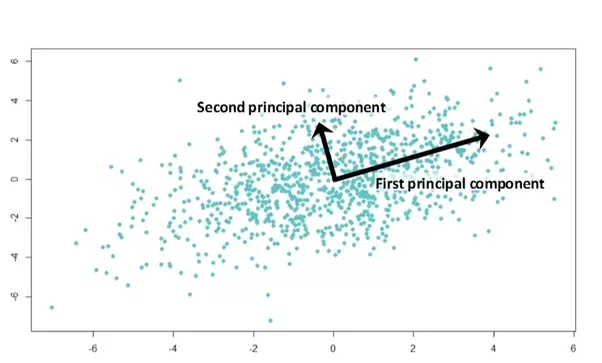

In [2]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename="C:/Users/dsba/Downloads/ba/pca.png",width=400,height=450)

#### 1-1. PCA 과정  

   1. 기존의 점들을 새로운 성분의 축으로 project 시켰을 때 '****분산이 최대한 유지****' 되도록 하는 성분을 찾는 것.  
   2. 기존의 벡터 x와 새로운 기저 벡터 w를 이용해서 x를 w에 project 시킨 벡터를 구함.(이 과정에서 분산평균 0을 위해 data centering)
   3. project된 벡터의 분산 식을 도출하고 Lagrangian multiplier를 통해 조건식의 문제를 간편하게 표현해서 답을 구함.  
   4. EVD를 통해 행렬을 대각화하여, 고유값과 고유벡터를 구함.  
   5. 고유값은 새로운 성분의 분산임을 의미하고, 고유벡터는 새로운 성분의 벡터를 의미함.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

X = df.iloc[:, 0:4].values
y = df.iloc[:,4].values

X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0) #data centering - PCA는 가우시안 분포에 적합하기 때문에 처리해줘야 함.  

In [3]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1) #centering된 행렬을 이용해 공분산 행렬을 만든다.
eig_vals, eig_vecs = np.linalg.eig(cov_mat) #공분산 행렬을 이용해 고유값과 고유벡터를 구함.

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))] 
eig_pairs.sort(key = lambda x: x[0], reverse=True) #고유값과 벡터를 set으로 내림차순 정리.
total = sum(eig_vals) #총분산에 대한 비율을 알기 위한 값

explained_var = [(i/total) * 100 for i in sorted(eig_vals, reverse=True)] #전체에서 차지하는 %비율 계산
cum_var = np.cumsum(explained_var)# 누적 비율 계산.
print(explained_var)
print(cum_var)

[72.77045209380132, 23.03052326768065, 3.683831957627394, 0.5151926808906336]
[ 72.77045209  95.80097536  99.48480732 100.        ]


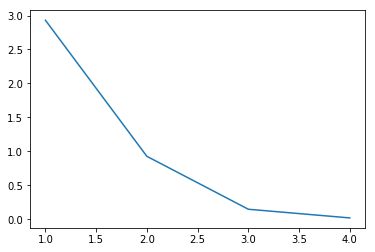

In [4]:
x=[1,2,3,4]
plt.plot(x, eig_vals) #고유값에 대한 scree plot.  3이면 , 첫 성분이 3개 정도의 변수를 설명하는 비중이라고 볼 수 있음.
                        #이를 바탕으로 적절한 개수의 성분을 선택.

In [5]:
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=2) #축 2개로 설정
Y_ = pca.fit_transform(X_std) #새로 설정된 성분으로 기존의 점들을 mapping
label = df['class'].unique()

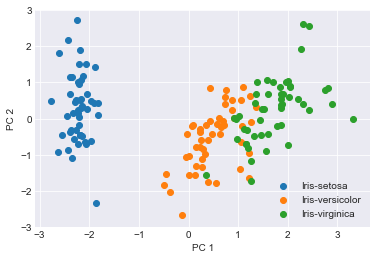

In [6]:
label = np.unique(label)
with plt.style.context("seaborn-darkgrid"):  
    for l in label:
        plt.scatter(Y_[y==l,0], Y_[y==l,1],label=l)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend()
    plt.show()

#### 1-2. PCA 특징  
    
   1. LDA는 분류를 목적으로 새로운 축을 생성하는 반면, PCA는 단순히 분산을 유지하는 방식으로 학습한다.  
   2. 도수분포표가 좌우대칭인, 가우시안 분포에 적합하다. - centering 과정이 필요
   3. 데이터의 손실은 적지만 원래의 변수의 의미가 복합적으로 반영되므로 축에 대한 해석이 주관적일 수 있다.  
   4. 변수자체의 해석보다는, 데이터의 차원이 너무 커서 모델에 학습하는 시간 비용을 줄이기 위해 이용.(영상인식에도 활용)

### 2. MDS (Multidimensional Dimension Scaling)
    -> 원 데이터의 정보(객체 간의 거리 즉, 객체 간 관계)를 가장 잘 보존하는 기저를 찾는 과정 (변수의 차원을 줄이면서)
    PCA와 다르게, 객체간의 거리 행렬만으로 원래 차원과 선택한 수만큼의 차원에로의 좌표를 찾을 수 있음.  
     + 고차원의 좌표가 있을 경우, 좌표를 이용해 거리 행렬을 만든 후, 객체간의 거리 정보를 알 수 있음.  
     
     output : 선택한 차원 수에 대해, 객체들의 새로운 좌표, 포지셔닝을 알 수 있음.

#### 2-1. MDS 과정
    
   1. 데이터들을 이용해 객체사이의 거리, 비유사도 거리를 나타내는 매트릭스를 형성(유킬리디언, 맨하탄, 자카드 등)  
   2. 거리를 $$D = (x_r-x_s)^T *(x_r-x_s)$$ 로 나타낸 후, 식을 전개하고, 시그마를 이용해서 일부 x의 제곱값들을 d로 대체하면 $$B = x_r^T*x_s$$를 거리 매트릭스의 선형결합을 이용해서 나타낼 수 있다.  
   
   
   3. 그러면 B가 symmetric하고 positive semi-definite한 행렬임을 이용해, 센터링을 거쳐 고유값을 분해한다.  
     (정방행렬에 적용, 직방행렬에는 SVD를 이용. / SVD의 특이값은 변환 자체의 scale factor고/ EVD는 방향벡터에 대한 scale factor)  
     
     
   4. 구해진 고유값 중 기존 변수 개수만큼까지를 잘라서(eigen value = non-zero만), B1으로 다시 설정한다.(원하는 차원 수 선택 가능)  
   
   
   5. 분해한 고유값을 이용해, 거꾸로 새 차원의 좌표들을 구함. (차원 수는 stress 값을 이용해 설정)  
       - 만약 맨 위의 B에 루트를 씌워서 원 좌표를 구할 수 있지만, 축소된 차원으로 매핑하기 위해 고유값을 분해한 뒤, 원하는 차원만큼만 자른 후 루트.
   
   
    + 행렬 A가 singular하다는것? 역행렬이 존재하지 않는다는것 . ? 대각화가 안된다는것. 고유값 존재 x ?  무슨의미인가.. 

In [7]:
import sklearn
from sklearn import manifold
df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')
X = df.iloc[:, 0:4].values
y = df.iloc[:,4].values

dists = np.zeros((len(X),len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        dists[i,j] = np.sqrt(np.sum((X[i,:]-X[j,:])**2)) #변수 i와 변수 j 사이의 거리를 제곱합의 제곱근으로 매트릭스화 함.

In [38]:
#X[:,0]
Y

array([[-2.68420713e+00,  3.26607315e-01,  2.15118370e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.71539062e+00, -1.69556848e-01,  2.03521425e-01, ...,
        -4.19455800e-10,  1.73278323e-10,  5.59125651e-11],
       [-2.88981954e+00, -1.37345610e-01, -2.47092410e-02, ...,
         9.27685382e-10,  2.94015886e-10,  1.14241988e-10],
       ...,
       [ 1.76404594e+00,  7.85191864e-02, -1.30784053e-01, ...,
         8.12562584e-10, -7.24166195e-10, -8.52929548e-11],
       [ 1.90162908e+00,  1.15876748e-01, -7.22873561e-01, ...,
        -2.23263120e-10, -3.73579313e-10,  3.12911490e-11],
       [ 1.38966613e+00, -2.82886709e-01, -3.62317832e-01, ...,
        -2.89762594e-09, -5.36014758e-10,  2.64966559e-10]])

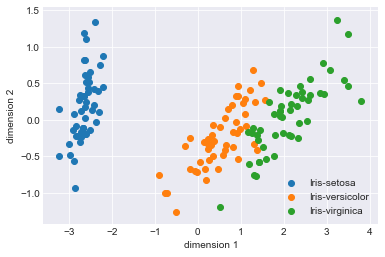

In [33]:
n = len(dists)

H = np.eye(n) - np.ones((n, n))/n

B = -H.dot(dists**2).dot(H)/2

eig_vals,eig_vecs = np.linalg.eigh(B) #symmetric matrix에서는 eigh사용.
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:,idx]

w = np.where(eig_vals > 0)
L = np.diag(np.sqrt(eig_vals[w]))
V = eig_vecs[:,w]
V = np.squeeze(V)
Y = V.dot(L)
import matplotlib.pyplot as plt
label = np.unique(y)
with plt.style.context("seaborn-darkgrid"):
    for l in label:
        plt.scatter(Y[y==l,0], Y[y==l,1],label=l) #고유값이 큰 순서대로 저장되어 있으므로, 가장 잘 설명하는 두 축에 대한 값만 plot 함.
    plt.xlabel("dimension 1")
    plt.ylabel("dimension 2")
    plt.legend()
    plt.show()

In [40]:
eig_vecs[:,0]

array([-0.10698373, -0.1082266 , -0.11517876, -0.10946401, -0.1087528 ,
       -0.09086926, -0.11243149, -0.10468299, -0.11510459, -0.10657071,
       -0.09990197, -0.10415133, -0.11109801, -0.12854595, -0.105363  ,
       -0.09501324, -0.10452533, -0.10555349, -0.08764806, -0.10312317,
       -0.09209024, -0.10136503, -0.12817358, -0.09179518, -0.09390928,
       -0.09995739, -0.0984085 , -0.10212853, -0.10521465, -0.10493672,
       -0.10316764, -0.09605781, -0.10552615, -0.10351429, -0.10657071,
       -0.11426925, -0.10463303, -0.10657071, -0.11884651, -0.10324181,
       -0.11040869, -0.11367981, -0.1195023 , -0.09587593, -0.08803686,
       -0.10823754, -0.10113938, -0.11320593, -0.10134315, -0.10776911,
        0.05120771,  0.03716285,  0.0583527 ,  0.00721276,  0.04332963,
        0.02552572,  0.04365204, -0.02995102,  0.04158244, -0.00040614,
       -0.02037023,  0.0203707 ,  0.01045585,  0.0392208 , -0.00696951,
        0.03697003,  0.02628921,  0.00934802,  0.03755946,  0.00

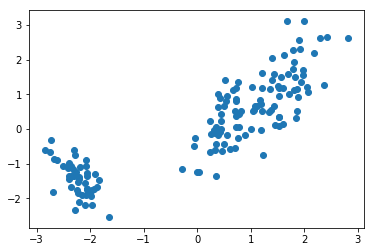

In [57]:
mds = sklearn.manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=3,
                   dissimilarity="precomputed", n_jobs=1)
out=mds.fit_transform(dists)
plt.scatter(out[:,0],out[:,1])

#### 2-2. MDS 특징  
    
   1. 원래 차원에서의 거리순서를 고려하면서 저차원으로의 거리순서가 유지되도록 하는 차원을 구함.  
   2. 시각적으로 객체간의 거리를 (유사한 정도를) 쉽게 해석하기 위해서 저차원으로 mapping 하는 것.  
   3. 이 또한 변수 자체의 해석보다는, 타겟으로 설정한 변수들이 어떤 관계를 가지는지, 객체들간의 관계를 보기쉽게 포지셔닝하는데 이용.
   